In [112]:
cd /home/daliu/Src/spykshrk_realtime/

/home/daliu/Src/spykshrk_realtime


In [113]:
import dask
import dask.dataframe as dd
import dask.array as da
from dask.base import tokenize
import numpy as np
import pandas as pd
import ipyparallel as ipp
import functools
import time
import h5py
import math

from spykshrk.franklab.pp_decoder.util import Groupby

dask.set_options(get=dask.multiprocessing.get)

pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

In [207]:
%%time

rc = ipp.Client()
dview = rc[:]

delay_counter = int(1e4)

def mean_func(data):
    import numpy as np
    return np.mean(data, axis=0)

def custom_mean_func(data):
    import numpy as np
    return np.mean(data, axis=1, keepdims=True)

def wait_func(data):
    import numpy as np
    global delay_counter
    for ii in range(delay_counter*np.prod(data.shape)):
        j = ii + ii
    return np.mean(data, axis=0)

def custom_wait_func(data):
    import numpy as np
    global delay_counter
    for ii in range(delay_counter*np.prod(data.shape)):
        j = ii + ii
    return np.mean(data, axis=1)

test_func = wait_func
custom_test_func = custom_wait_func
dview.push(dict(test_func=test_func))
dview.push(dict(custom_test_func=custom_test_func))
dview.push(dict(delay_counter=delay_counter))


data_mag = int(1e5)
bin_size = int(1e4)
data_size = 8
count1 = pd.DataFrame(np.arange(data_mag), columns=['first'])
count2 = pd.DataFrame((np.arange(data_mag)/bin_size).astype('int'), columns=['second'])
data_col = pd.DataFrame(np.ones([data_mag, data_size]), columns=[str(ii) for ii in range(data_size)])

test_df = count1.join([count2, data_col])

test_df.to_hdf('/tmp/tmp.h5', key='/a', format='table')

with h5py.File('/tmp/tmp_np.h5', 'w') as f:
    grp_list = []
    for grp_id, grp in test_df.groupby('second'):
        grp_list.append(grp.values)

    f.create_dataset('a', data=np.array(grp_list))


CPU times: user 1.16 s, sys: 349 ms, total: 1.51 s
Wall time: 1.01 s


In [115]:
%%time
## Test dask.DataFrame parallelization with in memory data source
test_dask = dd.from_pandas(test_df, npartitions=10)
dask_frame_task = test_dask.groupby('second').apply(test_func, meta=test_dask)
dask_frame_results = dask_frame_task.compute()

CPU times: user 804 ms, sys: 2.55 s, total: 3.35 s
Wall time: 3min 4s


In [237]:
%%time

def func1(s):
    for ii in range(delay_counter*s.size().values[0]):
        j = ii + ii
    return s.sum(), s.count()

def func2(sum, count):
    return sum.sum(), count.sum()

def func3(sum, count):
    return sum / count

custom_mean = dd.Aggregation('custom_mean', func1, func2, func3)

test_dask2 = dd.from_pandas(test_df, npartitions=10)

dask_agg_task = test_dask2.groupby('second').agg(custom_mean)

dask_agg_results = dask_agg_task.compute()


CPU times: user 234 ms, sys: 1.77 s, total: 2.01 s
Wall time: 47.6 s


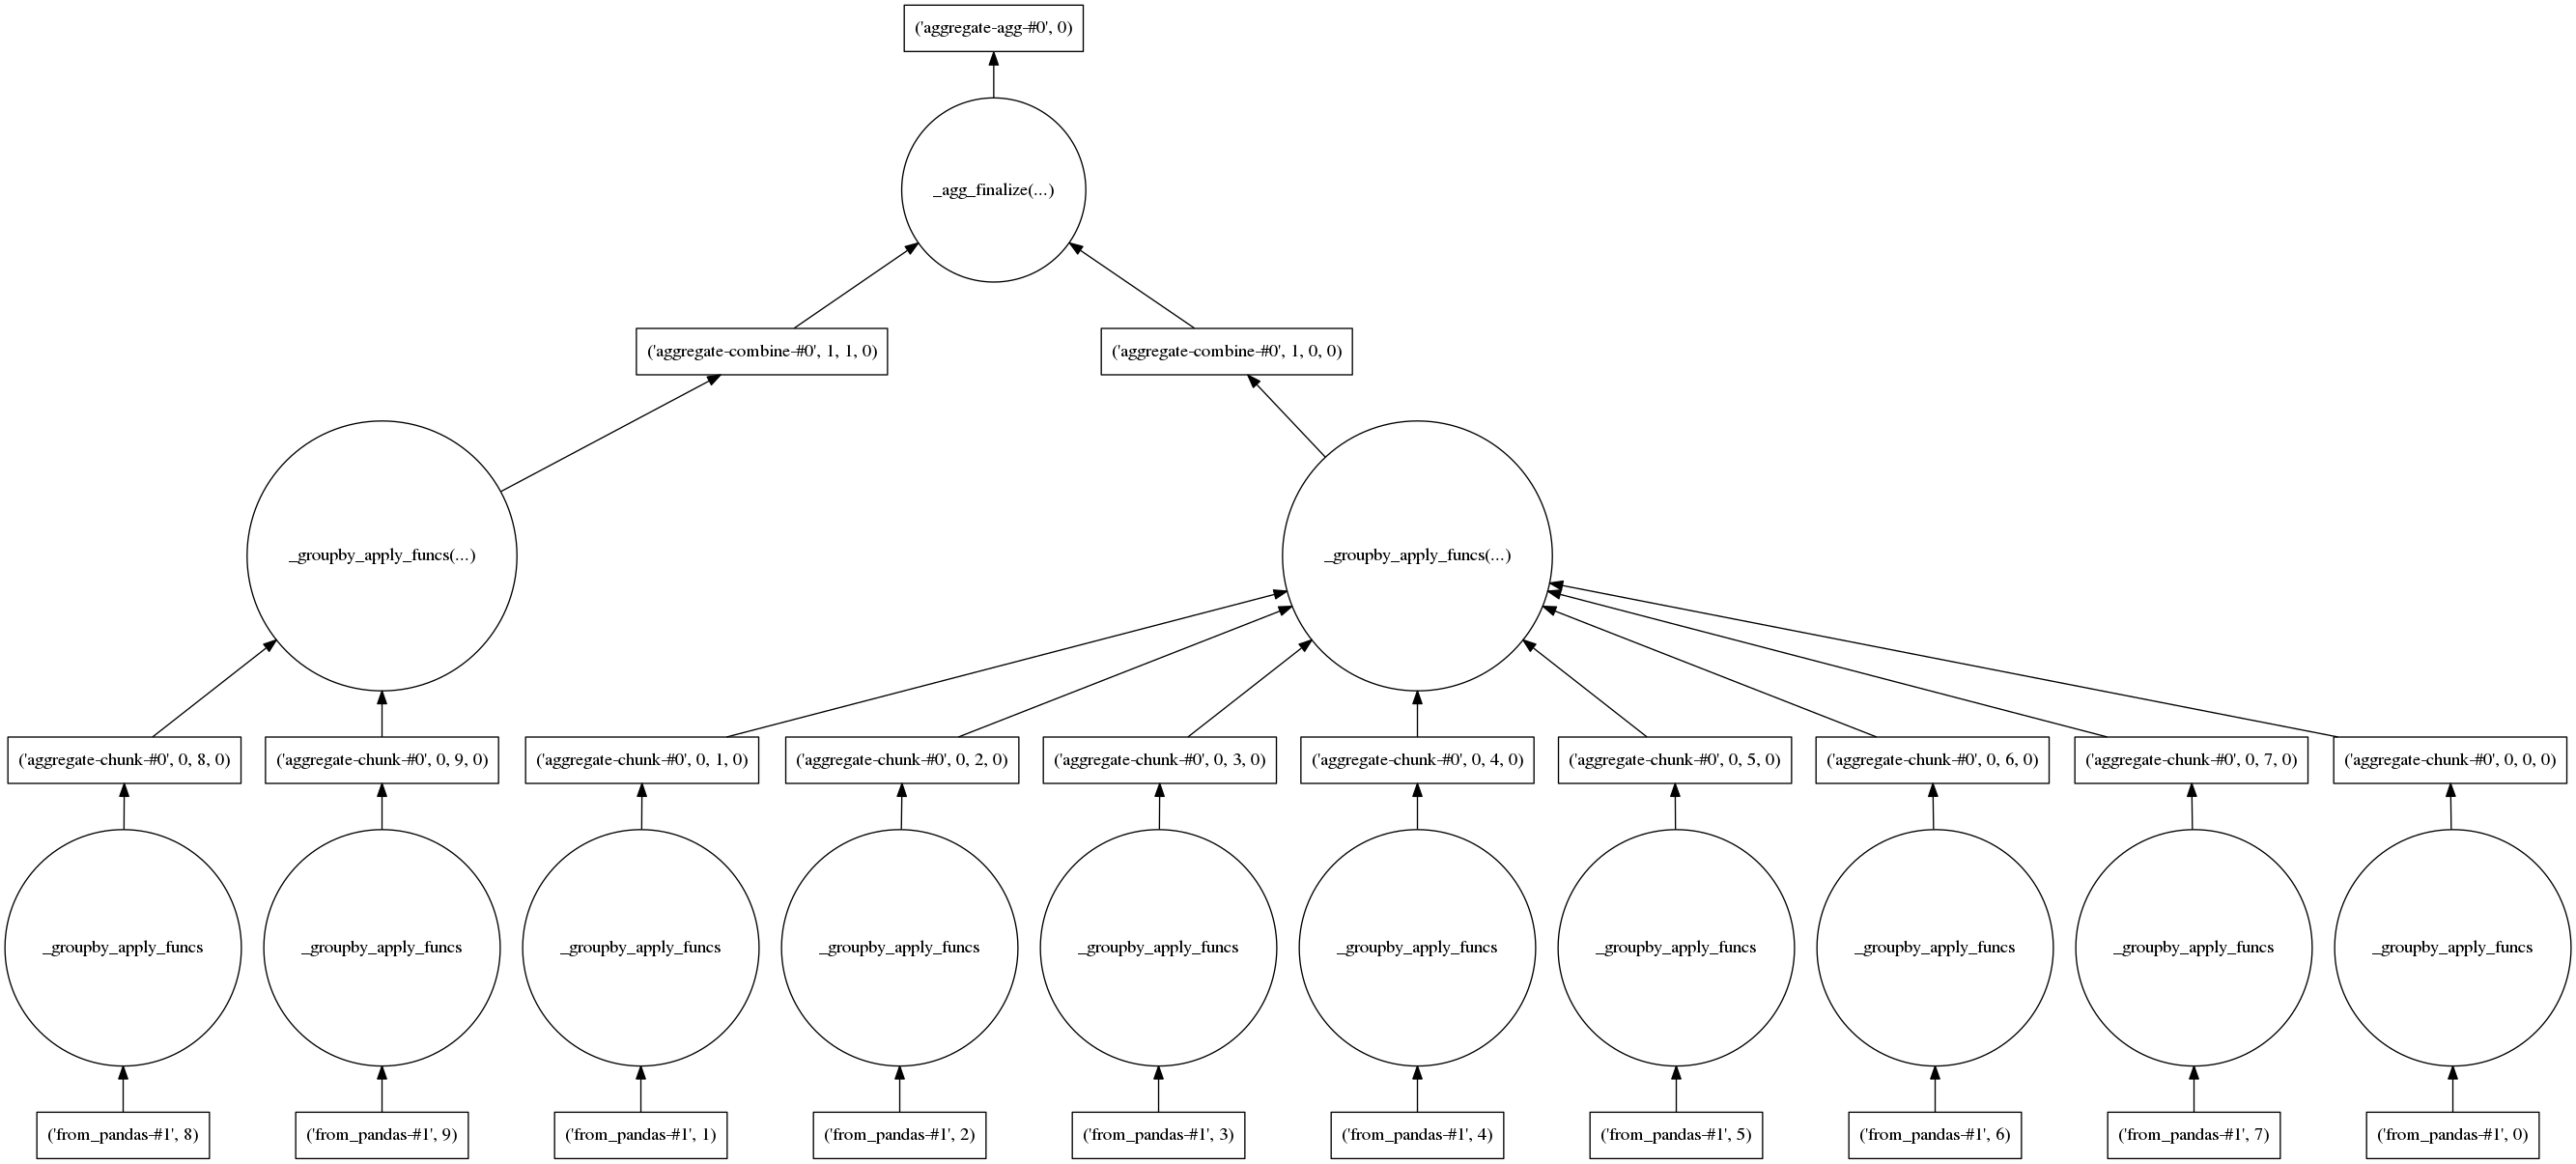

In [238]:
dask_agg_task.visualize()

In [235]:
%%time

def func1(s):
    for ii in range(delay_counter*s.size().values[0]):
        j = ii + ii
    return s.sum(), s.count()

def func2(sum, count):
    return sum.sum(), count.sum()

def func3(sum, count):
    return sum / count

custom_mean = dd.Aggregation('custom_mean', func1, func2, func3)

dask_file1 = dd.read_hdf('/tmp/tmp.h5', key='/a', chunksize=int(1e4))

dask_file_agg_task = dask_file1.groupby('second').agg(custom_mean)

dask_agg_results = dask_file_agg_task.compute()


CPU times: user 236 ms, sys: 1.82 s, total: 2.05 s
Wall time: 47.9 s


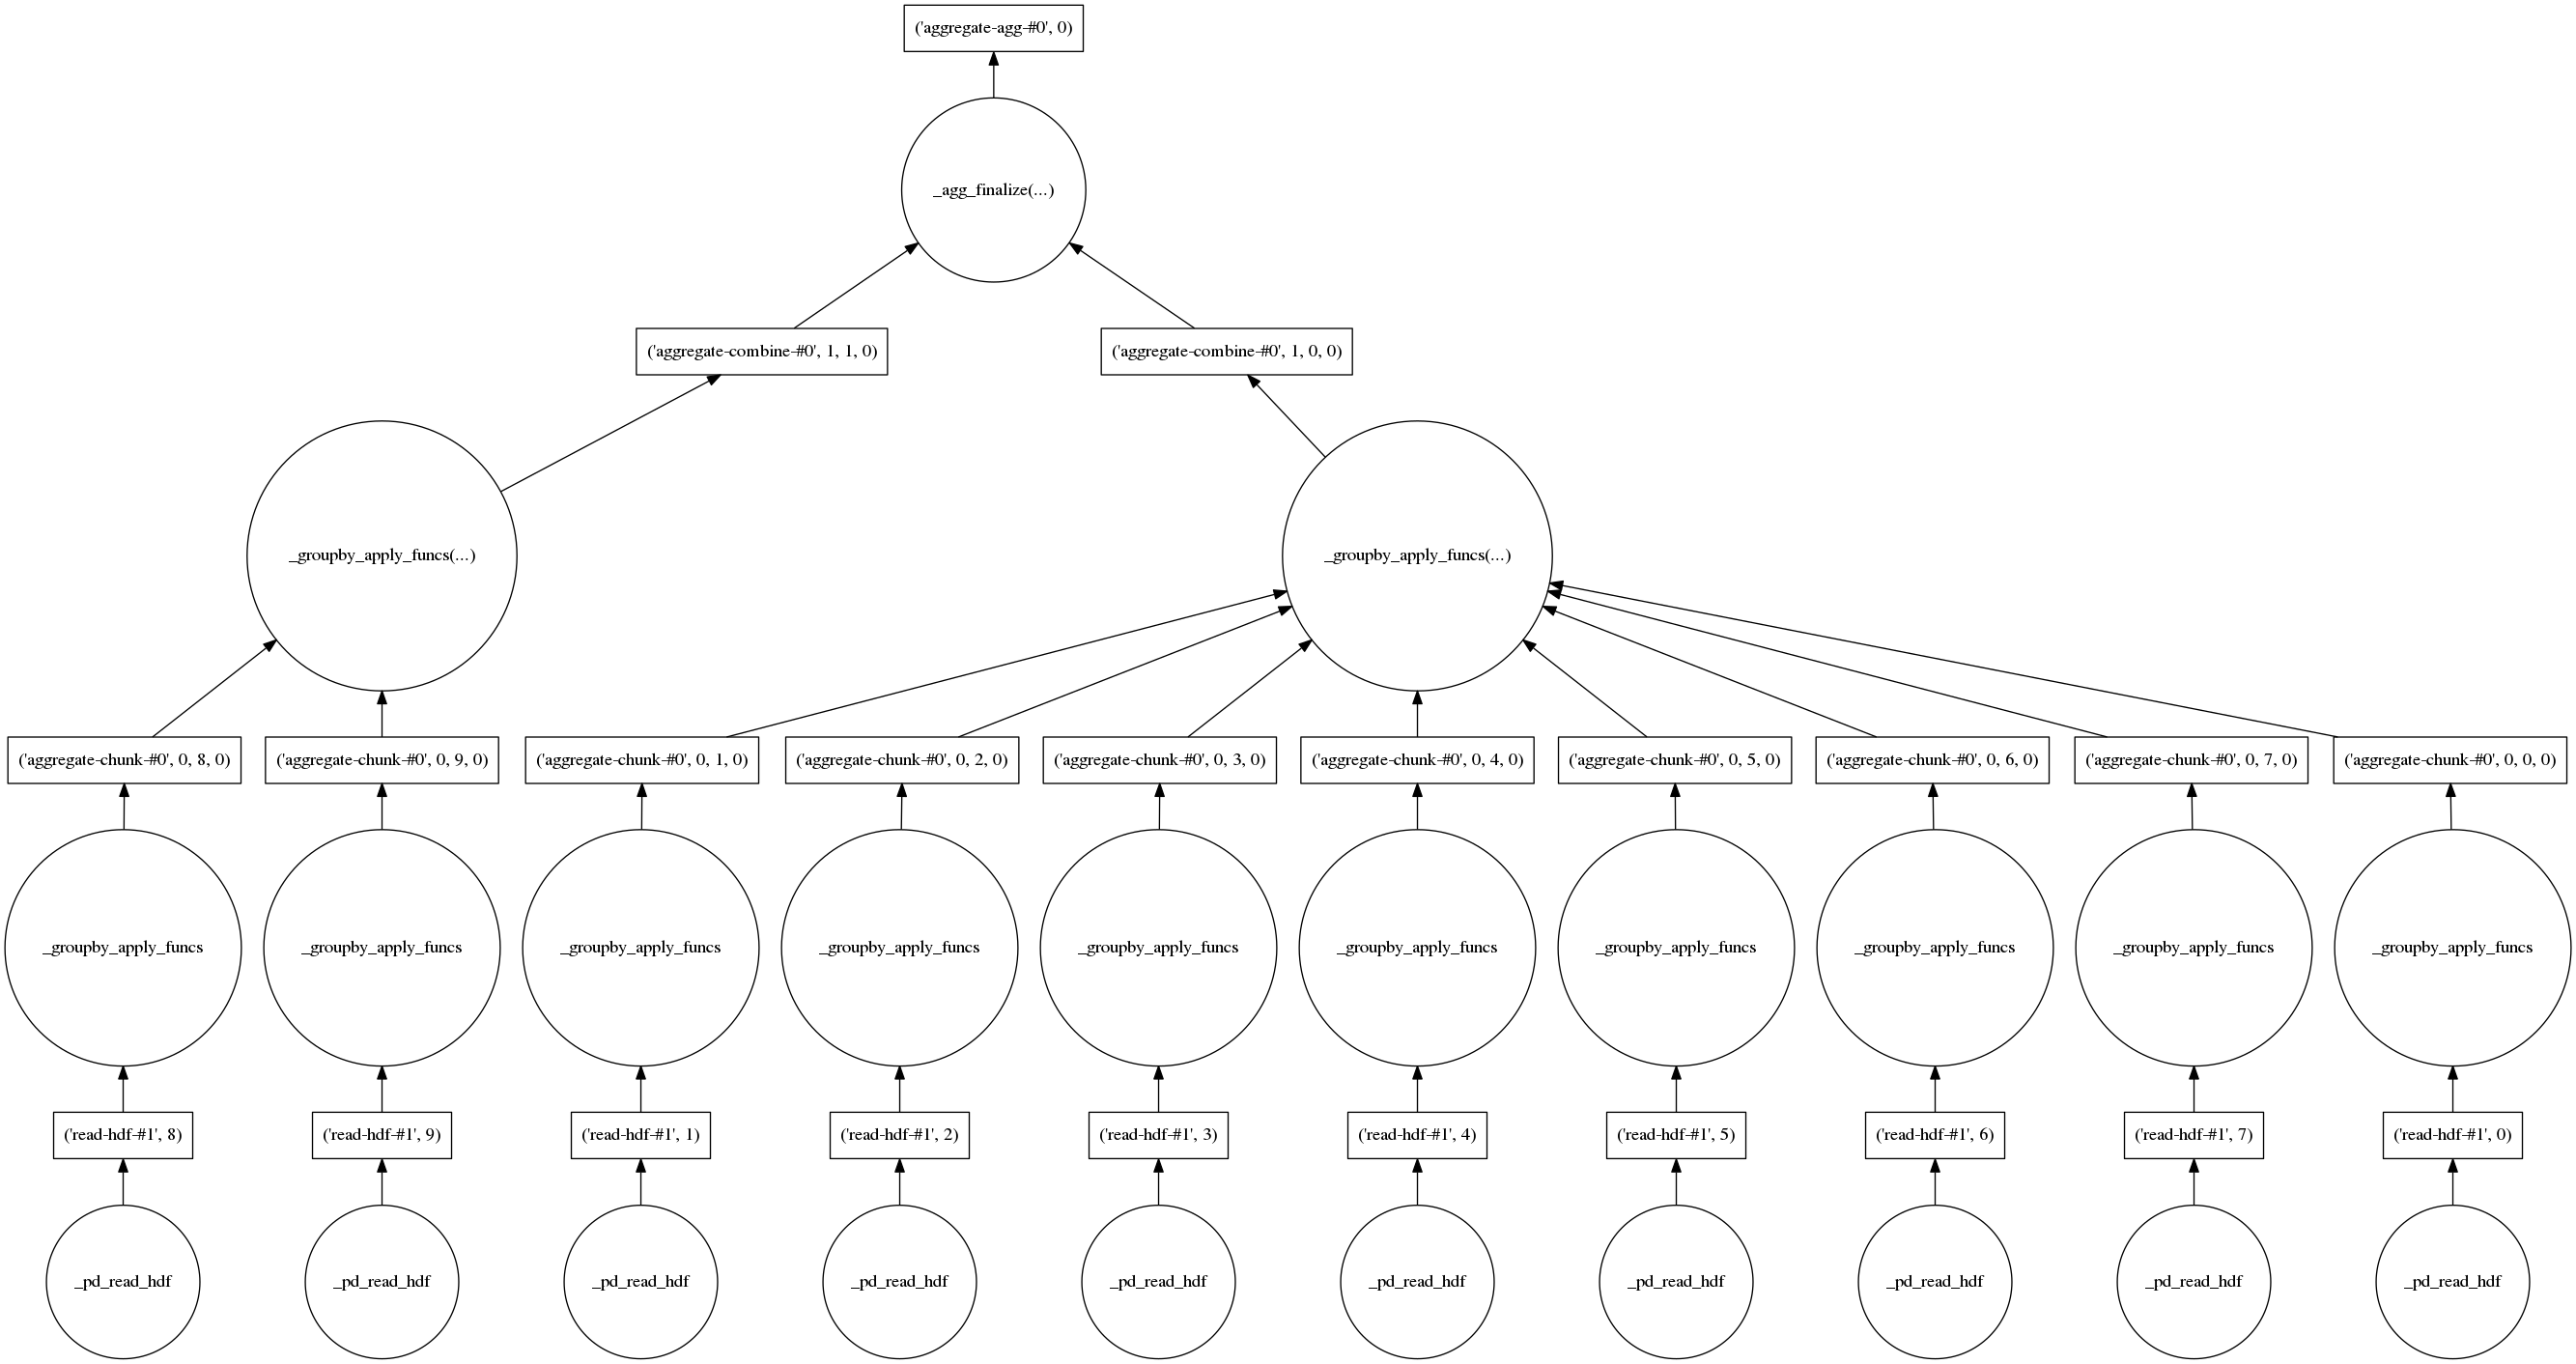

In [236]:
dask_file_agg_task.visualize()

In [232]:
%%time
## Test dask.DataFrame parallelization with file data source
dask_file2 = dd.read_hdf('/tmp/tmp.h5', key='/a', chunksize=int(1e4))
dask_file_frame_task = dask_file2.groupby('second').apply(test_func, meta=dask_frame_results)
dask_file_frame_results = dask_file_frame_task.compute()

CPU times: user 639 ms, sys: 2.19 s, total: 2.83 s
Wall time: 2min 59s


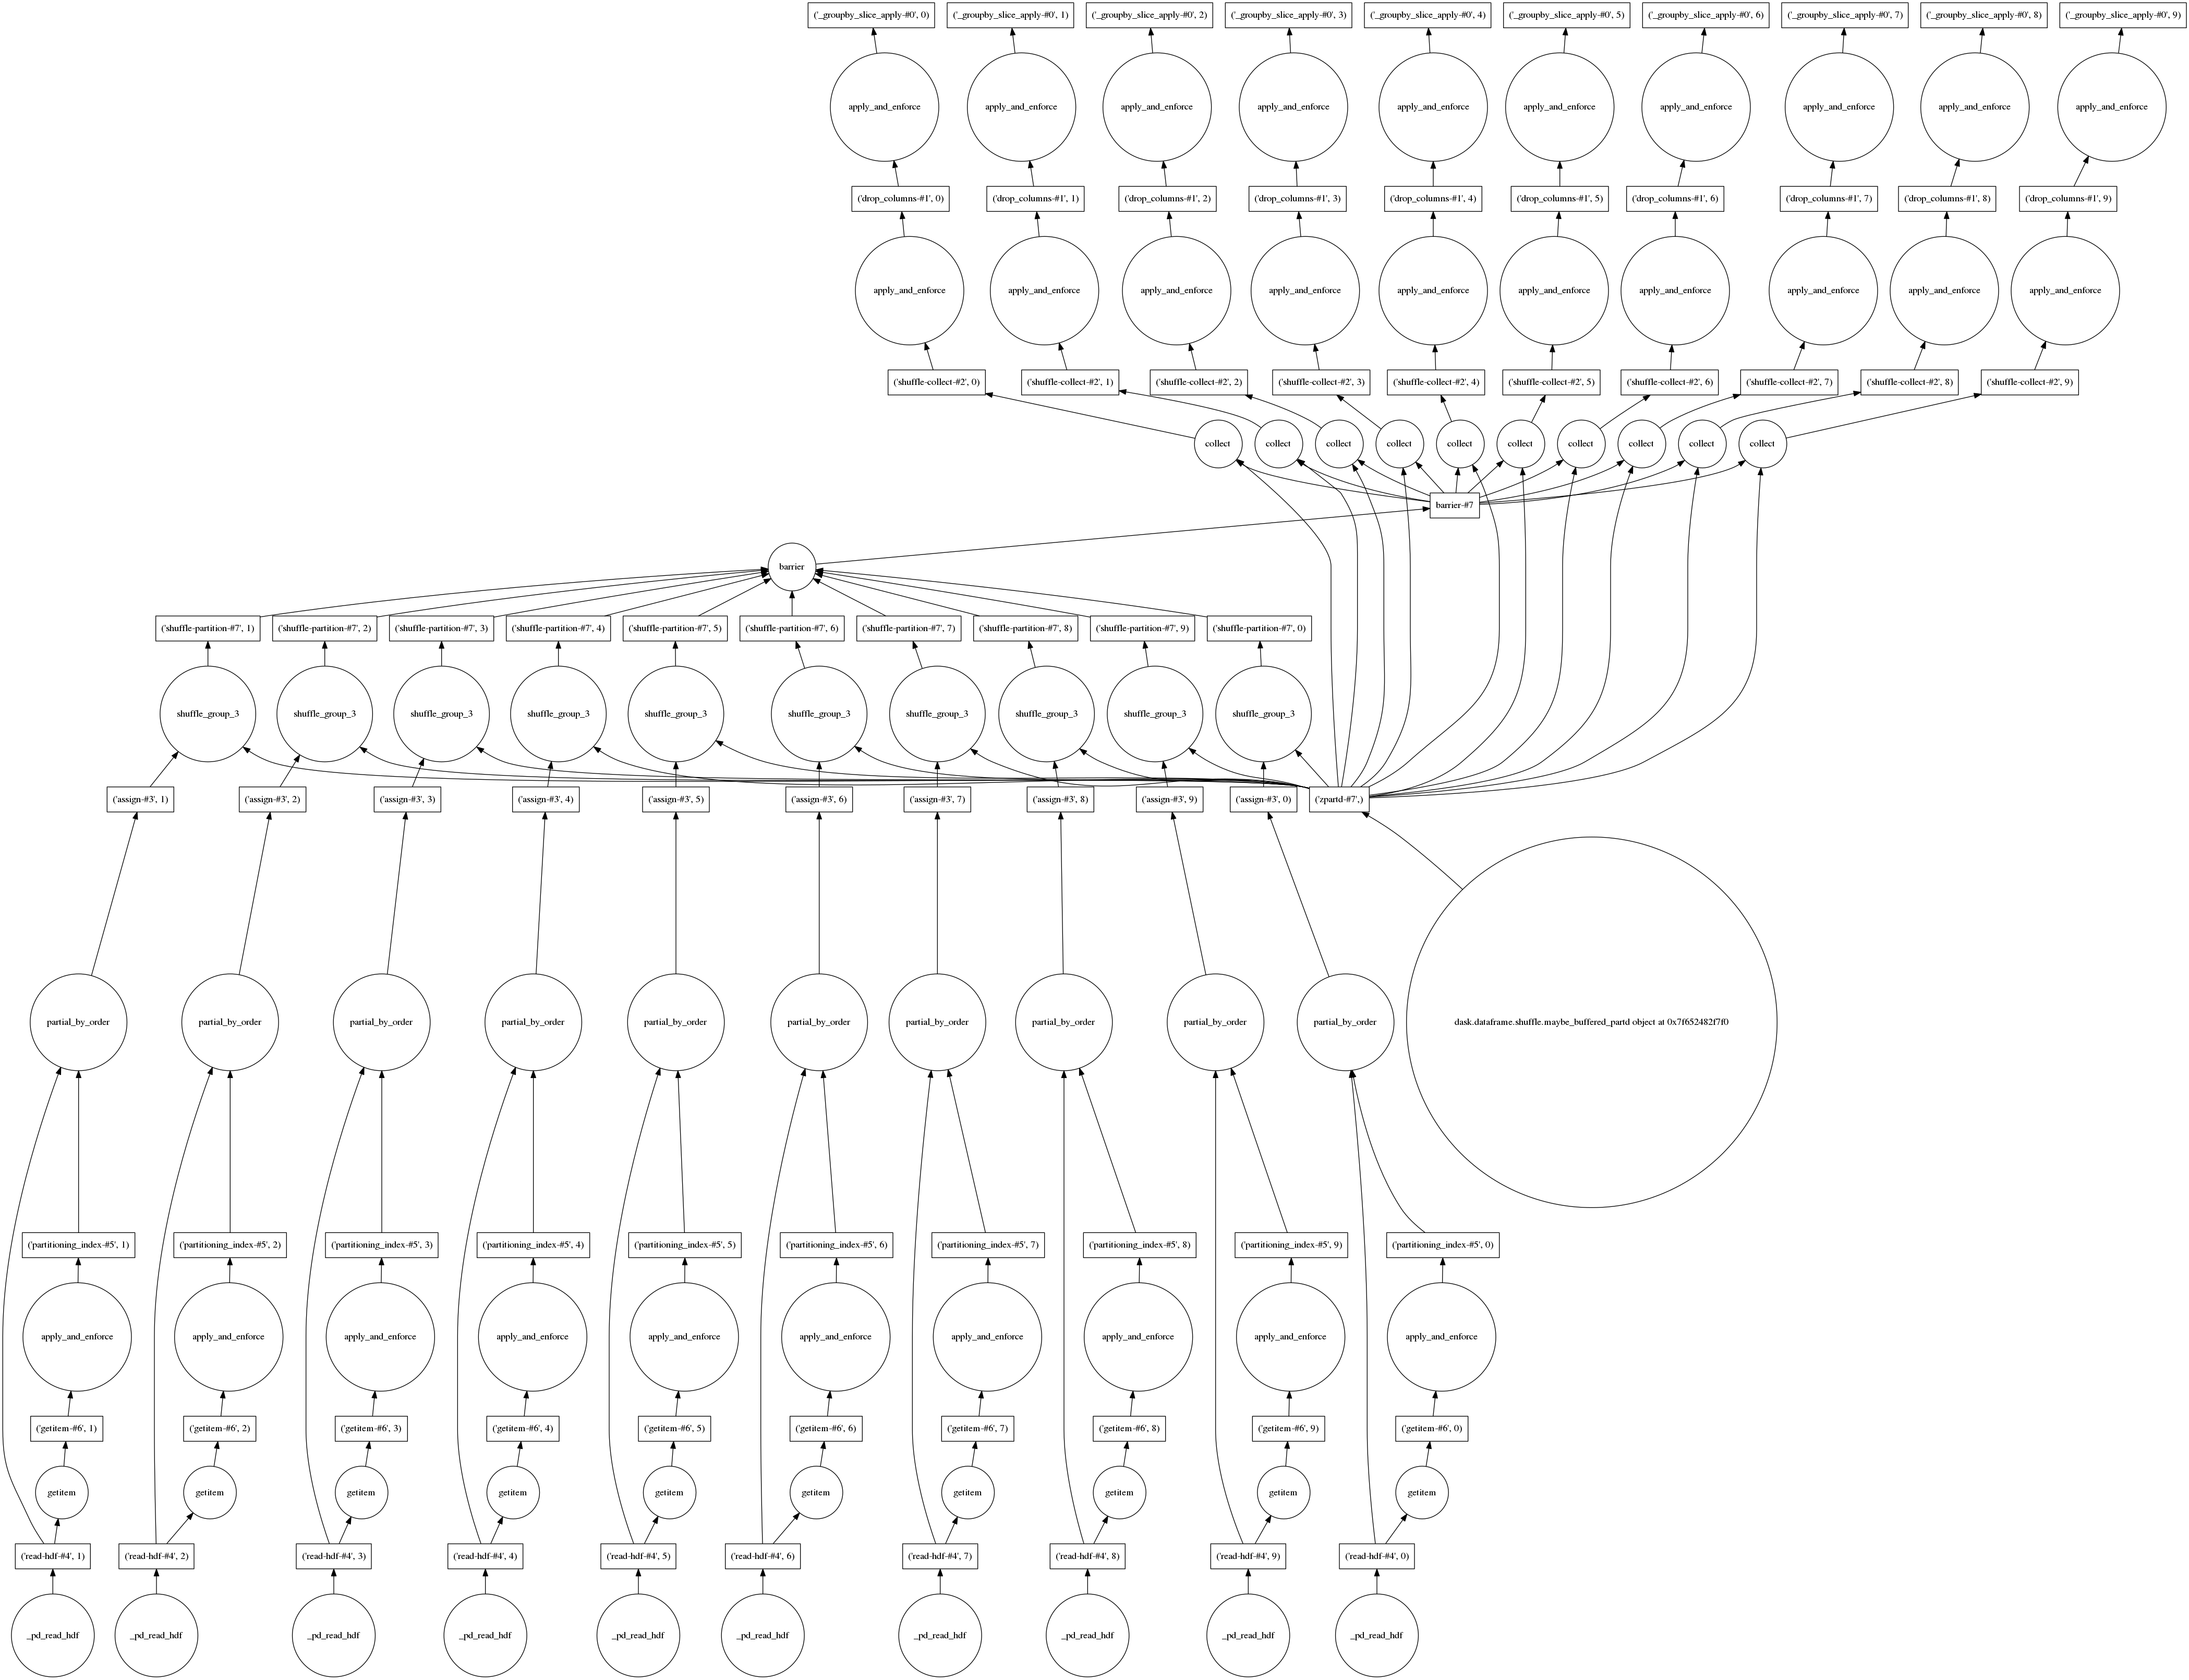

In [233]:
dask_file_frame_task.visualize()

In [222]:
%%time

def delayed_hdf5(path, dset, lo,hi):
    with h5py.File(path, mode='r',) as f:
        arr = f[dset][lo:hi]
    return arr

def daskify_hdf5_1d_array_delayed(
        path,
        dset,
        chunksize=int(1e6),
    ):
    
    with h5py.File(path, mode='r') as f:
        size = f[dset].shape
        dtype = f[dset].dtype
    
    chunk_edges = np.arange(0, size[0], chunksize)
    
    if chunk_edges[-1] != size[0]:
        chunk_edges = np.r_[chunk_edges, size[0]]
        
    arrs = [da.from_delayed(
                dask.delayed(delayed_hdf5)(path, dset, lo, hi),
                (hi-lo, size[1], size[2]),
                dtype
            )
            for lo,hi in zip(chunk_edges[:-1],chunk_edges[1:])
           ]
    arr = da.concatenate(arrs)
        
    return arr

dask_file_arr = daskify_hdf5_1d_array_delayed('/tmp/tmp_np.h5', 'a', chunksize=1)
dask_file_arr_task = da.apply_along_axis(test_func, arr=dask_file_arr, axis=1)
dask_file_arr_results = dask_file_arr_task.compute()
#dask_file_arr.compute()


CPU times: user 117 ms, sys: 1.78 s, total: 1.9 s
Wall time: 52.7 s


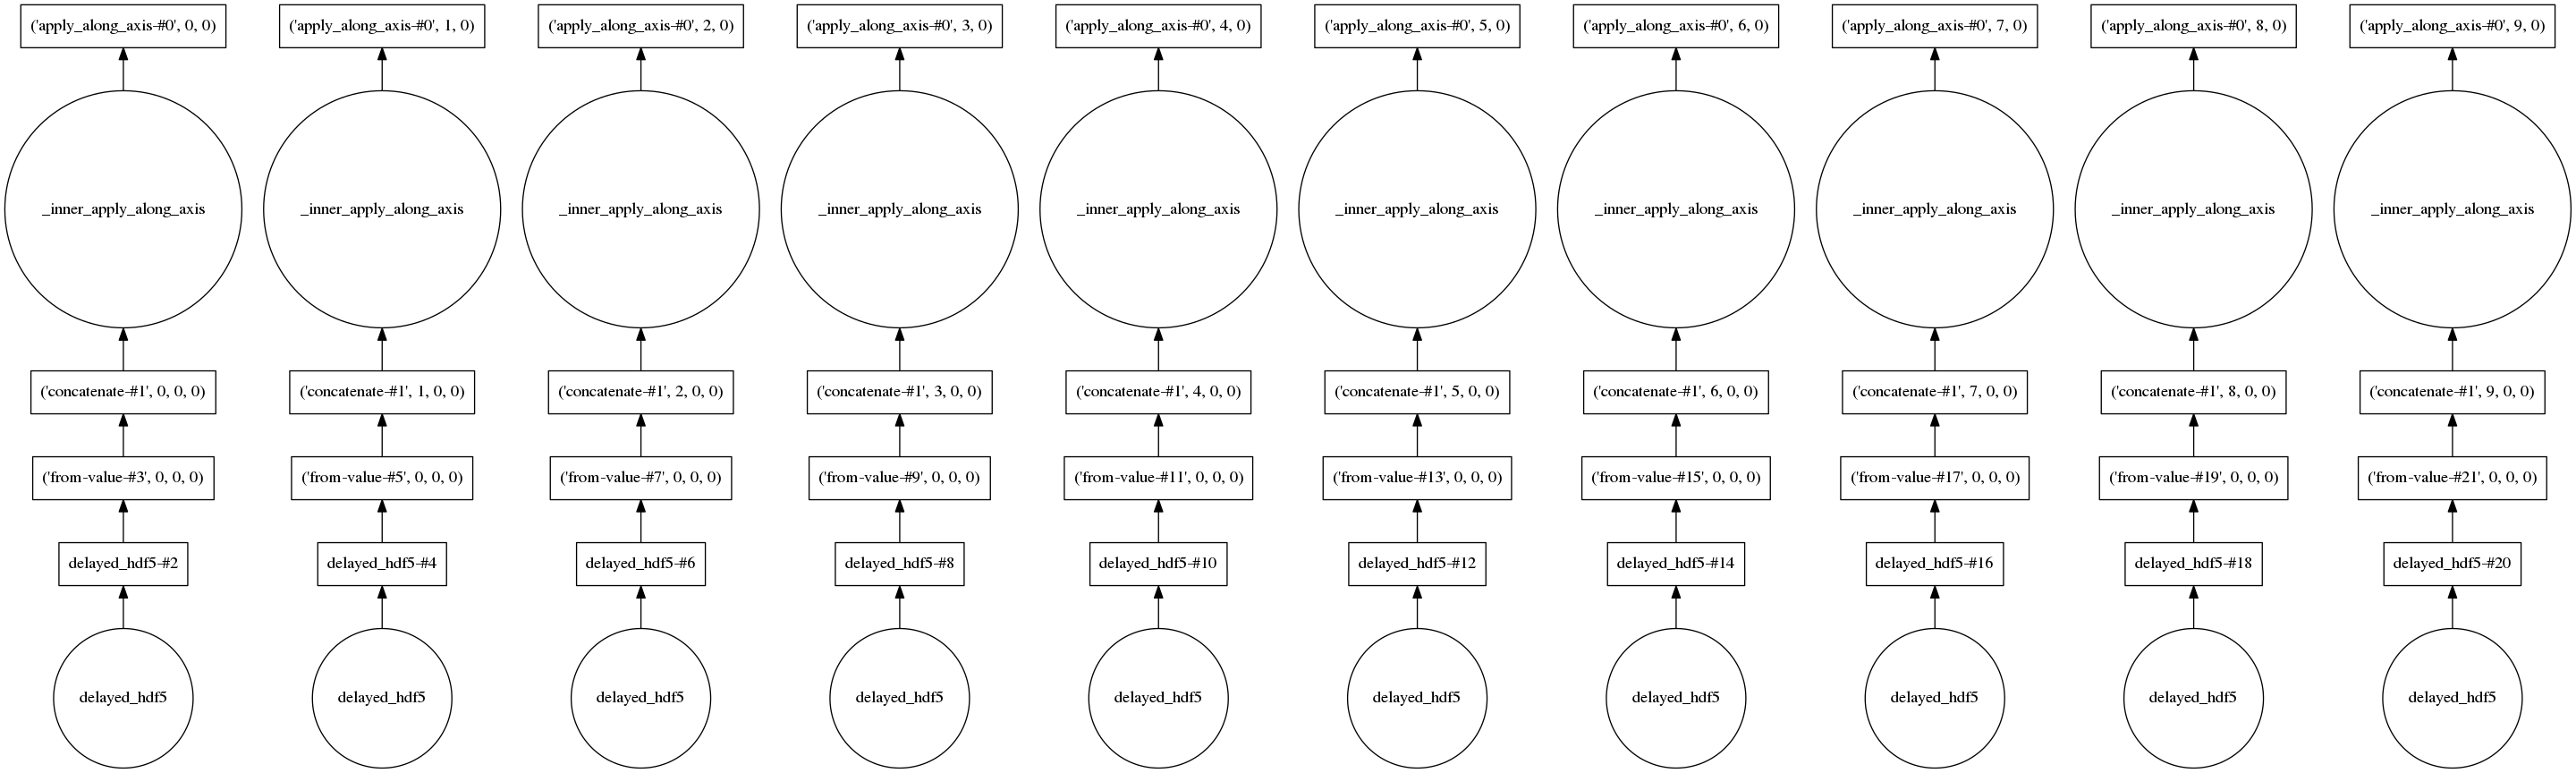

In [221]:
dask_file_arr_task.visualize()

In [118]:
%%time
## Test dask.Array parallelization with in memory data source
grp_obj1 = Groupby(test_df.values, test_df['second'])
array_data1 = np.array(list(grp_obj1))
dask_array1 = da.from_array(array_data1, chunks=(data_mag/bin_size/10, bin_size, data_size+2))
dask_array_task1 = da.apply_along_axis(test_func, arr=dask_array1, axis=1)
# task = da.apply_along_axis(np.mean, arr=task, axis=1)
dask_array_results1 = dask_array_task1.compute()

CPU times: user 258 ms, sys: 2.01 s, total: 2.27 s
Wall time: 53.4 s


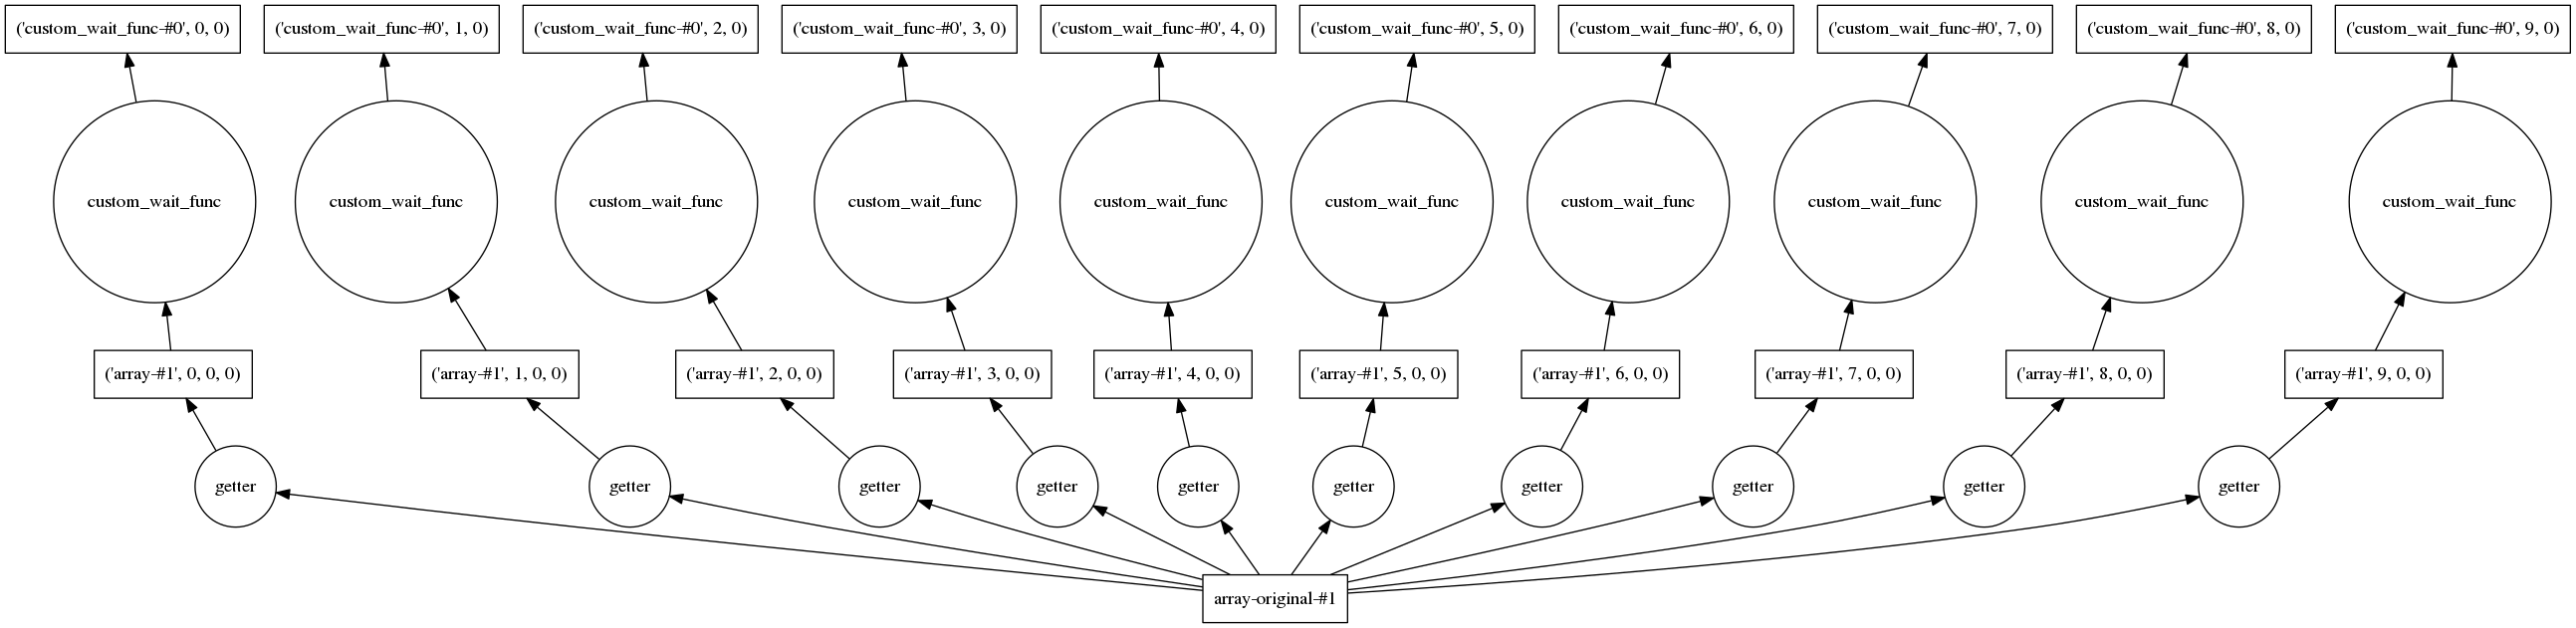

In [239]:
dask_array_task1.visualize()

In [120]:
%%time
## Test dask.Array mean parallelization
grp_obj2 = Groupby(test_df.values, test_df['second'])
dask_array2 = da.from_array(np.array(list(grp_obj2)), chunks=(data_mag/bin_size/10, bin_size, data_size+2))
dask_array_mean_results = dask_array2.mean(axis=1).compute()

CPU times: user 226 ms, sys: 1.79 s, total: 2.01 s
Wall time: 2.09 s


In [121]:
%%time
grp_obj3 = Groupby(test_df.values, test_df['second'])

def combine_grp_results(results_list):
    return np.array(results_list)

delay_result_list = []
for grp_entry in grp_obj3:
    delay_result_list.append(dask.delayed(custom_test_func)(grp_entry))

delay_task = dask.delayed(combine_grp_results)(delay_result_list)

delay_results = delay_task.compute()

CPU times: user 277 ms, sys: 1.73 s, total: 2 s
Wall time: 56 s


In [144]:
%%time
## Test custom function dask.Array parallelization

def benchmark_mean(v):
    
    name = 'benchmark_mean-' + tokenize(v)
    new_chunk = [v.chunks[0], v.chunks[2]]
    dsk = {(name, i, k): (custom_test_func, (v.name, i, j, k))
           for i in range(len(v.chunks[0]))
           for j in range(len(v.chunks[1]))
           for k in range(len(v.chunks[2]))}
    dsk.update(v.dask)
    dtype = v.dtype
    
    return da.Array(dsk, name, new_chunk, dtype)

grp_obj3 = Groupby(test_df.values, test_df['second'])
dask_array3 = da.from_array(np.array(list(grp_obj3)), chunks=(data_mag/bin_size/10, bin_size, data_size+2))
custom_dask_array_task = benchmark_mean(dask_array3)
custom_dask_array_results = custom_dask_array_task.compute()

CPU times: user 282 ms, sys: 1.95 s, total: 2.23 s
Wall time: 57.1 s


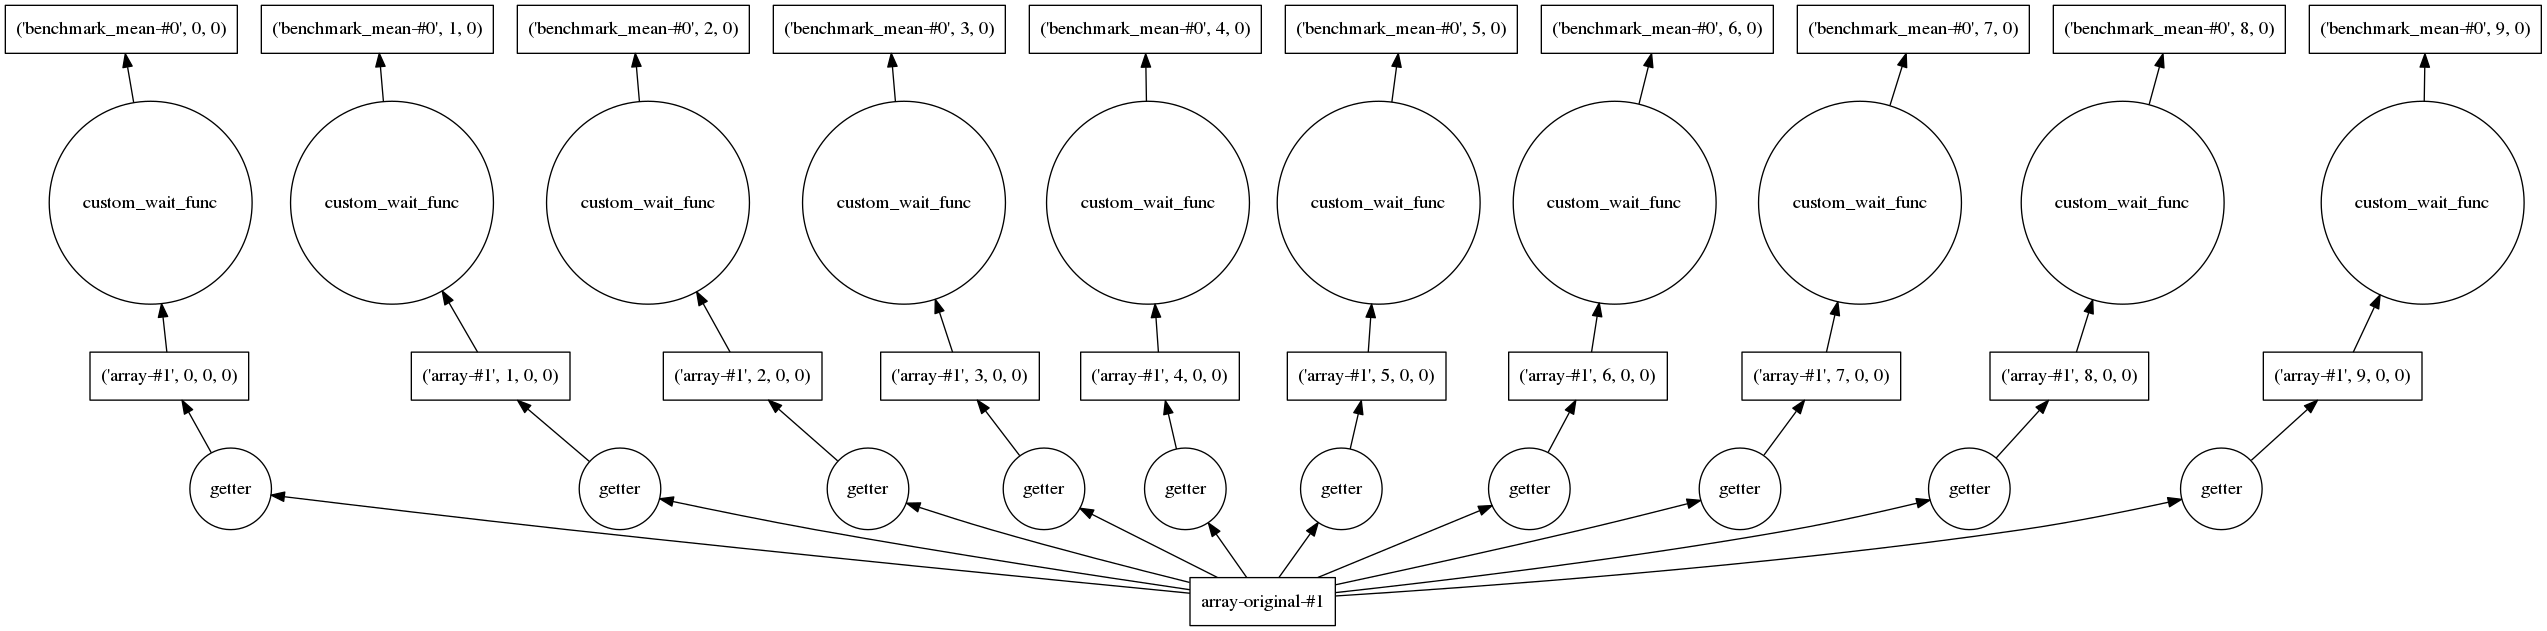

In [123]:
from dask.dot import dot_graph
dot_graph(custom_dask_array_task.dask)

In [124]:
%%time
grp_obj = Groupby(test_df.values, test_df['second'])
new_grp = np.array(list(grp_obj))
ipp_results = np.array(dview.map_sync(test_func, new_grp))

CPU times: user 340 ms, sys: 104 ms, total: 443 ms
Wall time: 52.9 s


In [223]:
%%time

def ipp_file_test(rank):
    import h5py
    import numpy as np
    with h5py.File('/tmp/tmp_np.h5', 'r') as f:
        data = f.get('a')
        sub_data = data[rank,:,:]
        return test_func(sub_data)

ipp_file_results = np.array(dview.map_sync(ipp_file_test, range(10)))
    

CPU times: user 447 ms, sys: 95.4 ms, total: 542 ms
Wall time: 51.5 s


In [126]:
%%time
def ipp_grp_test(grp_entry):
    import numpy as np
    grp_id, df = grp_entry
    return test_func(df)

pd_grp = test_df.groupby('second')
pd_ipp_results = np.array(dview.map_sync(ipp_grp_test, pd_grp))

CPU times: user 441 ms, sys: 152 ms, total: 593 ms
Wall time: 50.7 s


In [127]:
%%time

grp = test_df.groupby('second')
pd_results1 = grp.apply(test_func)

CPU times: user 7min 30s, sys: 8.76 ms, total: 7min 30s
Wall time: 7min 30s


In [128]:
%%time

grp = test_df.groupby('second')
pd_results2 = grp.mean()

CPU times: user 18.6 ms, sys: 0 ns, total: 18.6 ms
Wall time: 17.3 ms


In [145]:
%%time
    for ii in range(delay_counter*np.prod(test_df.shape)):
        j = ii + ii

CPU times: user 15min 7s, sys: 0 ns, total: 15min 7s
Wall time: 15min 7s
